In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Coursework_2/Data/
#%cd /content/drive/My Drive/Machine_Learning/Coursework_2/Data/

/content/drive/.shortcut-targets-by-id/1voRRD_g2foZIlz66vzdgW3frWbY0kmkR/Coursework_2/Data


User defined variables here - generally increasing these numbers gives a larger training set and a more thorough 

In [3]:
user_num_bootstrap_samples = 1000
user_subsample_no = 100000
user_num_epochs = 20

In [4]:
!pip install miceforest
!pip install numpy==1.20.3

!pip install tensorflow==2.7.0
!pip install scikeras
!pip install tensorflow_addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.3 which is incompatible.
jaxlib 0.4.7+cuda11.cudnn86 requires numpy>=1.21, but you ha

In [5]:
# Clean the memory

import gc
gc.collect()

25

In [6]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import math
import matplotlib.pyplot as plt
import missingno
from plotly.offline import init_notebook_mode,iplot,plot
import plotly.graph_objects as go

from pathlib import Path
import os
from matplotlib import pyplot
import scipy.sparse
import miceforest as mf


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow_addons.metrics import RSquare

import scikeras
from scikeras.wrappers import KerasRegressor
from keras import initializers

from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from statsmodels.stats.outliers_influence import variance_inflation_factor


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and

In [7]:
#Attempt to make code as reproducible as possible

np.random.seed(1)
tf.random.set_seed(2)

Memory optimisation

In [8]:
def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df

Preprocessing functions

In [9]:
def breakdown_timestamp(df):
    
    df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'])

    df.loc[:, 'hour'] = np.int8(df['timestamp'].dt.hour)
    
    df.loc[:, 'day'] = np.int16(df['timestamp'].dt.day)
    df.loc[:, 'dayofweek'] = np.int8(df['timestamp'].dt.dayofweek)
    df.loc[:, 'dayofyear'] = np.int16(df['timestamp'].dt.dayofyear)

    df.loc[:, 'month'] = np.int8(df['timestamp'].dt.month)

    df.loc[:, 'year'] = np.int16(df['timestamp'].dt.year)

    df = df.drop("timestamp",axis=1)
    
    return df


def impute(df):

  ### Simple Median Imputer

  numerical_cols = ["precip_depth_1_hr", "sea_level_pressure"]

  imp = SimpleImputer(strategy = "median")

  ct = make_column_transformer(
      (imp, numerical_cols),
      remainder='passthrough')
  
  ct.set_output(transform='pandas')
  df_imputed = ct.fit_transform(df)

  # rename columns back to originals
  df_imputed.columns = df_imputed.columns.str.replace("remainder", "").str.replace("simpleimputer","").str.replace("__","")

  df_imputed = df_imputed.loc[:, df_imputed.columns]


  ### More complex MICE Random Forest Imp method

  # Create kernel. 
  kds = mf.ImputationKernel(
    df_imputed,
    save_all_iterations=False,
    random_state=1991
  )

  kds.mice(5)

  df_imputed = kds.complete_data()

  return df_imputed

def encode(df):
  columns = ['primary_use', 'meter']
  primuse_categories = df['primary_use'].unique()
  meter_categories = df['meter'].unique()

  enc = OneHotEncoder(sparse_output=False)

  transformer = make_column_transformer((enc, columns))
  transformed = transformer.fit_transform(df)

  primuse = pd.DataFrame(
      transformed, 
      columns = transformer.get_feature_names_out(),
      index = df.index
      )
      
  for column in transformer.get_feature_names_out():
    df[column] = primuse[column]

  df_encoded = df.drop(['primary_use', 'meter'], axis='columns')

  return df_encoded


def scale_dataframe(df, exclude_cols=None):

  df_scaled = df.copy()
  cols_to_scale = df_scaled.columns.difference(exclude_cols)
  scaler = MinMaxScaler()
  df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

  return df_scaled


def preprocess(df):
  df.loc[:, 'meter'].replace({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}, inplace=True)

  df_dropped_rows = df.dropna(subset=["air_temperature", "dew_temperature", "wind_speed"])
  
  print("Percentage of records lost through dropping missing value rows:", "{:.1%}".format((1-len(df_dropped_rows)/len(df))))
  
  df_ts = breakdown_timestamp(df_dropped_rows)

  df_imputed = impute(df_ts)
  print("locerror")


  df_encoded = encode(df_imputed)

  df_scaled = scale_dataframe(df_encoded, exclude_cols=["meter_reading"]).drop(['site_id', 'building_id'], axis=1)
  
  return df_scaled

Use bootstrapping to generate multiple predictions to allow us to evaluate 95% confidence intervals on model performance metrics

In [10]:
def ci(bootstrap_samples):
  # Calculate the mean and standard deviation of the MSEs of the bootstrap samples
  bootstrap_samples_mean = np.mean(bootstrap_samples)
  bootstrap_samples_std = np.std(bootstrap_samples)

  # Calculate the 95% confidence interval on the MSE
  bootstrap_samples_ci = (bootstrap_samples_mean - 1.96 * bootstrap_samples_std, 
                          bootstrap_samples_mean + 1.96 * bootstrap_samples_std)
  
  return bootstrap_samples_ci


def model_performance_metrics(Y_pred, Y_test, num_bootstrap_samples = user_num_bootstrap_samples):
  Y_pred = ANN_model.predict(X_test).squeeze()
  Y_test = Y_test.reset_index().drop("index", axis=1)

  # Bootstrapping to get confidence intervals on the MSE
  mse_bootstrap_samples = []  # Placeholders
  rmse_bootstrap_samples = [] 
  rscore_bootstrap_samples = [] 
  mae_bootstrap_samples = [] 

  for i in range(num_bootstrap_samples):
      # Resample the dataset with replacement
      indices = np.random.choice(len(Y_test), size=len(Y_test), replace=True)
      Y_test_resampled = Y_test.iloc[indices]
      Y_pred_resampled = Y_pred[indices]
      
      # Compute the MSE of the resampled dataset
      mse_bootstrap_samples.append(mean_squared_error(Y_test_resampled, Y_pred_resampled))
      rmse_bootstrap_samples.append(mean_squared_error(Y_test_resampled, Y_pred_resampled, squared = False))
      rscore_bootstrap_samples.append(r2_score(Y_test_resampled, Y_pred_resampled))
      mae_bootstrap_samples.append(mean_absolute_error(Y_test_resampled, Y_pred_resampled))

  # Calculate the 95% confidence intervals
  mse_ci = ci(mse_bootstrap_samples)
  rmse_ci = ci(rmse_bootstrap_samples)
  rscore_ci = ci(rscore_bootstrap_samples)
  mae_ci = ci(mae_bootstrap_samples)

  return [mse_ci, 
          rmse_ci, 
          rscore_ci, 
          mae_ci]

In [11]:
### Read

train_data = pd.read_csv('train.csv')
building_data = pd.read_csv('building_metadata.csv')
weather_train_data = pd.read_csv('weather_train.csv')




### Reduce memory usage

train_data = reduce_mem_usage(train_data, 'Train Data')
building_data = reduce_mem_usage(building_data, 'Building Data')
weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')

### Merge


train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')


Memory usage of Train Data is reduced by 71.82 %. Usage dropped from 616.95 MB to 173.84 MB.
Memory usage of Building Data is reduced by 73.88 %. Usage dropped from 0.07 MB to 0.02 MB.
Memory usage of Weather Train Data is reduced by 73.06 %. Usage dropped from 9.60 MB to 2.59 MB.


In [12]:
def instance_selection(df, sample_size):
  # I think we need to shuffle the data before we sample from it. If there is an inherent order, we might be picking the dataset based on that
  # The code below samples the whole dataset again, which a shuffle based on the random seet set above (np.random_seed())

  df = df.sample(frac=1)

  n_samples = df.shape[0]
  indices = np.random.choice(n_samples, sample_size, replace=False)
  selected_instances = df.iloc[indices, :]
  return selected_instances
  

In [13]:
train_slim = instance_selection(train, user_subsample_no)
train_slim = train_slim.reset_index()
train_slim = train_slim.drop(columns = ["index"])
train_slim['meter'] = train_slim['meter'].astype('category')


In [14]:
train_slim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   building_id         100000 non-null  int16   
 1   meter               100000 non-null  category
 2   timestamp           100000 non-null  category
 3   meter_reading       100000 non-null  float32 
 4   site_id             100000 non-null  int8    
 5   primary_use         100000 non-null  category
 6   square_feet         100000 non-null  int32   
 7   year_built          39931 non-null   float16 
 8   floor_count         17489 non-null   float16 
 9   air_temperature     99523 non-null   float16 
 10  cloud_coverage      56088 non-null   float16 
 11  dew_temperature     99515 non-null   float16 
 12  precip_depth_1_hr   81342 non-null   float16 
 13  sea_level_pressure  93770 non-null   float16 
 14  wind_direction      92824 non-null   float16 
 15  wind_speed        

In [15]:
train_preprocessed = preprocess(train_slim)


Percentage of records lost through dropping missing value rows: 0.7%


<ipython-input-9-c235085b4446>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-c235085b4446>:3: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-9-c235085b4446>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-c235085b4446>:7: SettingWith

locerror


Implementation

In [16]:
del building_data, train, train_data, weather_train_data

In [17]:
gc.collect()

227

In [18]:
y_train = np.log1p(train_preprocessed['meter_reading']).squeeze()
x_train = train_preprocessed.drop(['meter_reading'], axis=1).squeeze() # getting the y and the x separately

In [19]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99285 entries, 0 to 99999
Data columns (total 36 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   precip_depth_1_hr                                         99285 non-null  float64
 1   sea_level_pressure                                        99285 non-null  float64
 2   square_feet                                               99285 non-null  float64
 3   year_built                                                99285 non-null  float64
 4   floor_count                                               99285 non-null  float64
 5   air_temperature                                           99285 non-null  float64
 6   cloud_coverage                                            99285 non-null  float64
 7   dew_temperature                                           99285 non-null  float64
 8   wind_direction  

In [20]:
# Getting the correlation between variables
bestfeatures = feature_selection.SelectKBest(f_regression, k='all')
fit = bestfeatures.fit(x_train.drop('month', axis='columns'),y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.drop('month', axis='columns').columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(29,'Score')) 

columns_to_keep = list(featureScores.nlargest(25,'Score')['Specs'])
print(columns_to_keep)


                                                Specs         Score
2                                         square_feet  15396.708634
4                                         floor_count   3472.734888
34                         onehotencoder__meter_steam   3403.760843
33                      onehotencoder__meter_hotwater    979.255122
32                   onehotencoder__meter_electricity    950.778628
15               onehotencoder__primary_use_Education    785.403869
16  onehotencoder__primary_use_Entertainment/publi...    458.025655
22                   onehotencoder__primary_use_Other    421.805554
3                                          year_built    329.728567
18              onehotencoder__primary_use_Healthcare    251.060377
13                                          dayofyear    211.365588
25       onehotencoder__primary_use_Religious worship    204.684478
26                  onehotencoder__primary_use_Retail    115.143889
10                                              

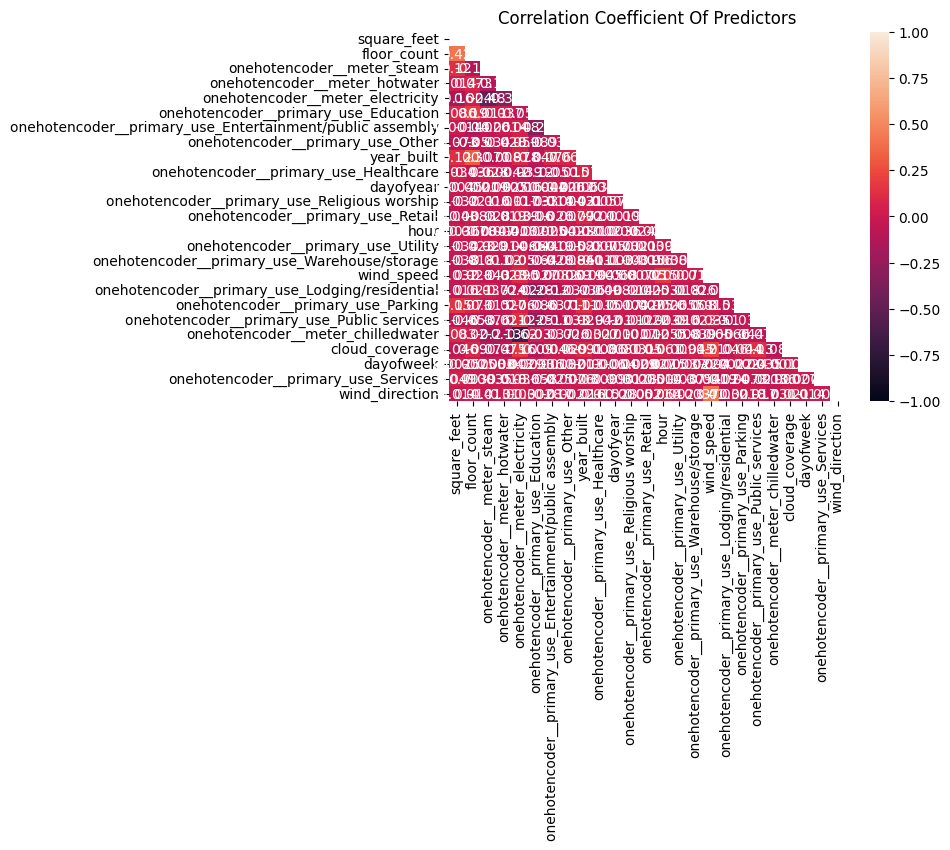

In [21]:
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(x_train[columns_to_keep].corr(), dtype=bool))

# generate heatmap
sns.heatmap(round(x_train[columns_to_keep].corr(),2), annot=True, mask=mask, vmin=0, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [22]:
def compute_vif(considered_features):
    
    X = x_train[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [23]:
vifs = compute_vif(x_train[columns_to_keep].columns)
print(vifs)

<ipython-input-22-fd8d4380cfa2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



                                             Variable       VIF
0                                         square_feet  1.333723
1                                         floor_count  1.476085
2                          onehotencoder__meter_steam       inf
3                       onehotencoder__meter_hotwater       inf
4                    onehotencoder__meter_electricity       inf
5                onehotencoder__primary_use_Education  1.677297
6   onehotencoder__primary_use_Entertainment/publi...  1.365862
7                    onehotencoder__primary_use_Other  1.057118
8                                          year_built  1.182737
9               onehotencoder__primary_use_Healthcare  1.078951
10                                          dayofyear  1.005304
11       onehotencoder__primary_use_Religious worship  1.007720
12                  onehotencoder__primary_use_Retail  1.029365
13                                               hour  1.025446
14                 onehotencoder__primar

/usr/local/lib/python3.9/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning:

divide by zero encountered in double_scalars



Split train data into 80% training data, 10% validation data and 10% test data.

In [24]:
x_train = x_train[columns_to_keep]

X_train, X_rem, Y_train, Y_rem = train_test_split(x_train, y_train, train_size=0.8)
X_test, X_val, Y_test, Y_val = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=12345)

Basic model based on a linear regression of only the most correlated variable.

In [55]:
lin_reg_model = LinearRegression()

lin_reg_model.fit(np.array(X_train['square_feet']).reshape(-1,1), Y_train)

Y_val_pred = lin_reg_model.predict(np.array(X_val['square_feet']).reshape(-1,1))

mean_squared_error(Y_val, Y_val_pred)
r2_score(Y_val, Y_val_pred)

0.13388317205491818

Artificial Neural Network

Picked a single hidden layer of 10 neurons as we have issues with overfitting based on the ANN model (low train MSE and high test MSE).

In [26]:
# Create an MLP model
ANN_model = keras.Sequential()

# Add input layer with specified input_dim
ANN_model.add(keras.layers.Input(shape=(25)))

# Add one or more hidden layers
ANN_model.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
ANN_model.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
ANN_model.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add output layer with linear activation for quantitative variable prediction
ANN_model.add(keras.layers.Dense(units=1, activation='linear', kernel_initializer = initializers.glorot_uniform(seed=0)))

# Compile the model with an appropriate optimizer, loss, and evaluation metric
ANN_model.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = ANN_model.fit(X_train, Y_train, epochs = user_num_epochs, batch_size=32, callbacks=[callback], validation_data=(X_val, Y_val))

Epoch 1/20
2483/2483 [==============================] - 11s 4ms/step - loss: 4.1012 - mae: 1.5171 - r_square: 0.1063 - root_mean_squared_error: 2.0251 - val_loss: 3.5522 - val_mae: 1.3607 - val_r_square: 0.2315 - val_root_mean_squared_error: 1.8847
Epoch 2/20
2483/2483 [==============================] - 6s 2ms/step - loss: 3.3615 - mae: 1.3457 - r_square: 0.2675 - root_mean_squared_error: 1.8334 - val_loss: 3.3209 - val_mae: 1.3434 - val_r_square: 0.2815 - val_root_mean_squared_error: 1.8223
Epoch 3/20
2483/2483 [==============================] - 12s 5ms/step - loss: 3.2362 - mae: 1.3165 - r_square: 0.2948 - root_mean_squared_error: 1.7989 - val_loss: 3.3056 - val_mae: 1.3059 - val_r_square: 0.2848 - val_root_mean_squared_error: 1.8181
Epoch 4/20
2483/2483 [==============================] - 6s 3ms/step - loss: 3.1515 - mae: 1.2985 - r_square: 0.3133 - root_mean_squared_error: 1.7752 - val_loss: 3.1698 - val_mae: 1.3176 - val_r_square: 0.3142 - val_root_mean_squared_error: 1.7804
Epoch 

In [28]:
#loss: 2.7826 - mae: 1.2016 - r_square: 0.3937 - root_mean_squared_error: 1.6681 - val_loss: 2.8984 - val_mae: 1.2138 - val_r_square: 0.3729 - val_root_mean_squared_error: 1.7

In [29]:
# 10 neurons, 15 variables: loss: 3.3179 - mae: 1.3355 - r_square: 0.2770 - root_mean_squared_error: 1.8215 - val_loss: 3.3744 - val_mae: 1.3302 - val_r_square: 0.2700 - val_root_mean_squared_error: 1.8369
# 7 neurons, 15 variables: loss: 3.4364 - mae: 1.3605 - r_square: 0.2512 - root_mean_squared_error: 1.8538 - val_loss: 3.4958 - val_mae: 1.3546 - val_r_square: 0.2437 - val_root_mean_squared_error: 1.8697
# 10 neurons, 15 variables, 2 layers: loss: 2.9744 - mae: 1.2551 - r_square: 0.3519 - root_mean_squared_error: 1.7247 - val_loss: 3.0164 - val_mae: 1.2625 - val_r_square: 0.3474 - val_root_mean_squared_error: 1.7368
# 10 neurons for first two layers, 3 for last, 15 variables, 3 layers: loss: 3.2402 - mae: 1.3127 - r_square: 0.2940 - root_mean_squared_error: 1.8000 - val_loss: 3.3064 - val_mae: 1.3263 - val_r_square: 0.2847 - val_root_mean_squared_error: 1.8183
# 10 neurons, 15 variables, 3 layers: loss: 2.8566 - mae: 1.2266 - r_square: 0.3775 - root_mean_squared_error: 1.6901 - val_loss: 2.9596 - val_mae: 1.2607 - val_r_square: 0.3597 - val_root_mean_squared_error: 1.7203

In [30]:
#original values: loss: 3.5108 - mae: 1.3559 - r_square: 0.2399 - root_mean_squared_error: 1.8737 - val_loss: 3.5144 - val_mae: 1.3783 - val_r_square: 0.2460 - val_root_mean_squared_error: 1.8747
#after choosing variables: loss: 3.5201 - mae: 1.3664 - r_square: 0.2386 - root_mean_squared_error: 1.8762 - val_loss: 3.6208 - val_mae: 1.3904 - val_r_square: 0.2280 - val_root_mean_squared_error: 1.9028
#after choosing variables + shuffling dataset: loss: 3.4389 - mae: 1.3458 - r_square: 0.2507 - root_mean_squared_error: 1.8544 - val_loss: 3.5117 - val_mae: 1.3343 - val_r_square: 0.2403 - val_root_mean_squared_error: 1.8740
#after encoding meter: loss: 3.3920 - mae: 1.3305 - r_square: 0.2604 - root_mean_squared_error: 1.8417 - val_loss: 3.4039 - val_mae: 1.3212 - val_r_square: 0.2587 - val_root_mean_squared_error: 1.8450

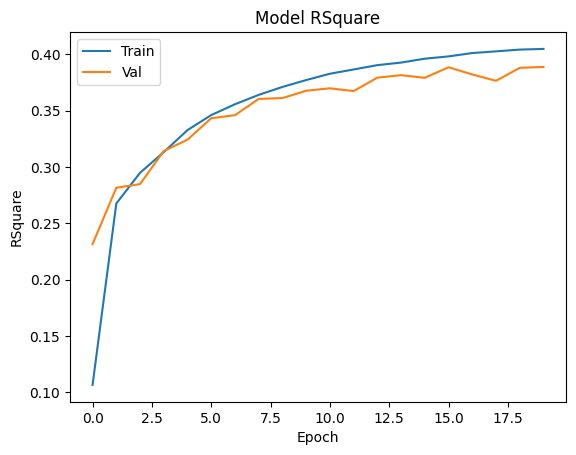

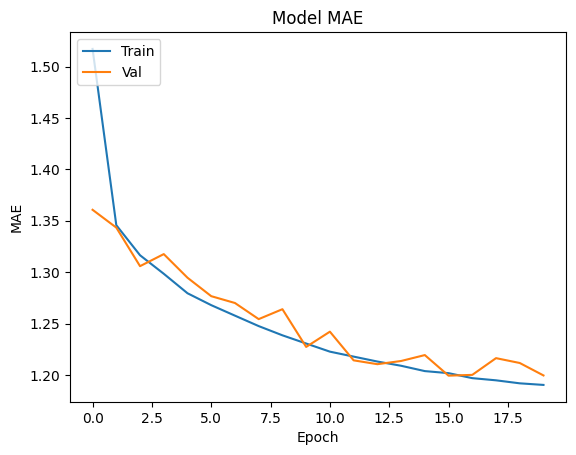

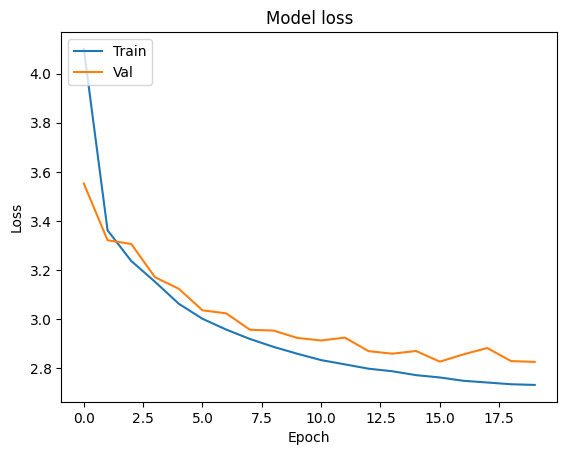

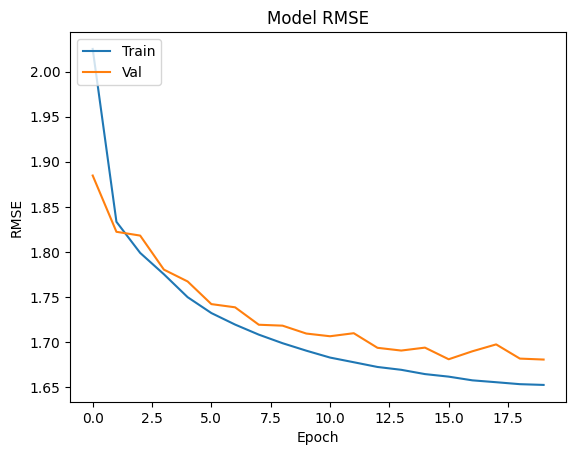

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['r_square'])
plt.plot(history.history['val_r_square'])
plt.title('Model RSquare')
plt.ylabel('RSquare')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [32]:
Y_pred = ANN_model.predict(X_test).squeeze()

ANN_model_metrics = model_performance_metrics(Y_pred, Y_test)

print("Base Artificial Neural Network Model Performance Metrics\n")
print("MSE 95% CI:", ANN_model_metrics[0])
print("RMSE 95% CI:", ANN_model_metrics[1])
print("R score 95% CI:", ANN_model_metrics[2])
print("MAE 95% CI:", ANN_model_metrics[3])

Base Artificial Neural Network Model Performance Metrics

MSE 95% CI: (2.658355997055769, 2.900676919966936)
RMSE 95% CI: (1.6307454773038625, 1.7034248641878367)
R score 95% CI: (0.3814006181471321, 0.4210838740519781)
MAE 95% CI: (1.162777604199946, 1.2100172623619436)


**Ensemble Learning Models**

In [33]:
# create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

Model 1 is a copy of our base ANN model

In [34]:
# Create an MLP model
model_1 = keras.Sequential()

# Add input layer with specified input_dim
model_1.add(keras.layers.Input(shape=(25)))

# Add one or more hidden layers
model_1.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
model_1.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
model_1.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add output layer with linear activation for quantitative variable prediction
model_1.add(keras.layers.Dense(units=1, activation='linear', kernel_initializer = initializers.glorot_uniform(seed=0)))

# Compile the model with an appropriate optimizer, loss, and evaluation metric
model_1.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_1.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

history = model_1.fit(X_train, Y_train, epochs = user_num_epochs, callbacks=[callback], validation_data=(X_val, Y_val))

Epoch 1/20
2483/2483 [==============================] - 10s 4ms/step - loss: 4.5314 - mae: 1.5837 - r_square: 0.0126 - root_mean_squared_error: 2.1287 - val_loss: 3.5614 - val_mae: 1.3782 - val_r_square: 0.2295 - val_root_mean_squared_error: 1.8872
Epoch 2/20
2483/2483 [==============================] - 6s 2ms/step - loss: 3.4118 - mae: 1.3569 - r_square: 0.2566 - root_mean_squared_error: 1.8471 - val_loss: 3.3761 - val_mae: 1.3682 - val_r_square: 0.2696 - val_root_mean_squared_error: 1.8374
Epoch 3/20
2483/2483 [==============================] - 8s 3ms/step - loss: 3.2776 - mae: 1.3258 - r_square: 0.2858 - root_mean_squared_error: 1.8104 - val_loss: 3.3208 - val_mae: 1.3113 - val_r_square: 0.2816 - val_root_mean_squared_error: 1.8223
Epoch 4/20
2483/2483 [==============================] - 8s 3ms/step - loss: 3.1855 - mae: 1.3009 - r_square: 0.3059 - root_mean_squared_error: 1.7848 - val_loss: 3.2110 - val_mae: 1.3274 - val_r_square: 0.3053 - val_root_mean_squared_error: 1.7919
Epoch 5

Model 2 is a variant of Model 1 with lower the number of neurons in the hidden layers

In [35]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Input(shape=(25)))
# Add one or more hidden layers
model_2.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
model_2.add(keras.layers.Dense(10, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

# Add one or more hidden layers
model_2.add(keras.layers.Dense(10, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))

model_2.add(keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.glorot_uniform(seed=0)))
print(model_2.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_2.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

history2 = model_2.fit(X_train, Y_train, epochs = user_num_epochs, callbacks=[callback], validation_data=(X_val, Y_val)) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 13)                338       
                                                                 
 dense_9 (Dense)             (None, 10)                140       
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 599
Trainable params: 599
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2483/2483 [==============================] - 7s 2ms/step - loss: 4.0665 - mae: 1.5230 - r_square: 0.1139 - root_mean_squared_error: 2.0166 - val_loss: 3.4887 - val_mae: 1.3

Model 3 is a variant of Model 1 with the hidden layer structure x4.

In [36]:
model_3 = keras.Sequential()
model_3.add(keras.layers.Input(shape=(25)))
model_3.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_3.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_3.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_3.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_3.add(keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.glorot_uniform(seed=0)))
print(model_3.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_3.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

history3 = model_3.fit(X_train, Y_train, epochs = user_num_epochs, callbacks=[callback], validation_data=(X_val, Y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 13)                338       
                                                                 
 dense_13 (Dense)            (None, 13)                182       
                                                                 
 dense_14 (Dense)            (None, 13)                182       
                                                                 
 dense_15 (Dense)            (None, 13)                182       
                                                                 
 dense_16 (Dense)            (None, 1)                 14        
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2483/2483 [=============================

In [37]:
model_4 = keras.Sequential()
model_4.add(keras.layers.Input(shape=(25)))
model_4.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_4.add(keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.glorot_uniform(seed=0)))
print(model_4.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_4.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

history4 = model_4.fit(X_train, Y_train, epochs = user_num_epochs, callbacks=[callback], validation_data=(X_val, Y_val))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 13)                338       
                                                                 
 dense_18 (Dense)            (None, 1)                 14        
                                                                 
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2483/2483 [==============================] - 7s 3ms/step - loss: 4.5181 - mae: 1.6189 - r_square: 0.0155 - root_mean_squared_error: 2.1256 - val_loss: 3.7283 - val_mae: 1.4338 - val_r_square: 0.1934 - val_root_mean_squared_error: 1.9309
Epoch 2/20
2483/2483 [==============================] - 5s 2ms/step - loss: 3.6028 - mae: 1.4162 - r_square: 0.2149 - root_mean_squared_error: 1.8981 - val_loss: 3.5414 - val_mae: 1.4099 - val_r_squa

In [38]:
model_5 = keras.Sequential()
model_5.add(keras.layers.Input(shape=(25)))
model_5.add(keras.layers.Dense(15, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_5.add(keras.layers.Dense(13, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_5.add(keras.layers.Dense(10, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_5.add(keras.layers.Dense(8, activation='relu', kernel_initializer=initializers.glorot_uniform(seed=0)))
model_5.add(keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.glorot_uniform(seed=0)))
print(model_5.summary())

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model_5.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

history3 = model_5.fit(X_train, Y_train, epochs = user_num_epochs, callbacks=[callback], validation_data=(X_val, Y_val))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 15)                390       
                                                                 
 dense_20 (Dense)            (None, 13)                208       
                                                                 
 dense_21 (Dense)            (None, 10)                140       
                                                                 
 dense_22 (Dense)            (None, 8)                 88        
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2483/2483 [=============================

Stacking using a Linear Regression Meta-Learner

In [39]:
all_models = list()

all_models.append(model_1)
all_models.append(model_2)
all_models.append(model_3)
all_models.append(model_4)
all_models.append(model_5)

In [40]:
# evaluate standalone models on test dataset
for model in all_models:
 mse, mae, rs, rmse = model.evaluate(X_test, Y_test)
 print('Model Accuracy: %.3f' % mse)

311/311 [==============================] - 1s 2ms/step - loss: 2.8604 - mae: 1.2038 - r_square: 0.3840 - root_mean_squared_error: 1.6913
Model Accuracy: 2.860
311/311 [==============================] - 1s 2ms/step - loss: 2.7757 - mae: 1.1738 - r_square: 0.4022 - root_mean_squared_error: 1.6660
Model Accuracy: 2.776
311/311 [==============================] - 1s 2ms/step - loss: 2.7838 - mae: 1.1769 - r_square: 0.4005 - root_mean_squared_error: 1.6685
Model Accuracy: 2.784
311/311 [==============================] - 1s 2ms/step - loss: 3.1239 - mae: 1.2738 - r_square: 0.3272 - root_mean_squared_error: 1.7675
Model Accuracy: 3.124
311/311 [==============================] - 1s 2ms/step - loss: 2.7378 - mae: 1.1706 - r_square: 0.4104 - root_mean_squared_error: 1.6546
Model Accuracy: 2.738


In [41]:
from sklearn.linear_model import LinearRegression

def stacked_dataset(all_models, X_input):
    X_stacked = None
    for model in all_models:
      # make prediction
      y_hat = model.predict(X_input, verbose=0)
      # stack predictions into [rows, members, probabilities]
      if X_stacked is None:
        X_stacked = y_hat
      else:
        X_stacked = np.dstack((X_stacked, y_hat))
    # flatten predictions to [rows, members x probabilities]
    X_stacked = X_stacked.reshape((X_stacked.shape[0], X_stacked.shape[1] * X_stacked.shape[2]))
    return X_stacked
  
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, X_input, Y_input):
  # create dataset using ensemble
  X_stacked = stacked_dataset(members, X_input)
  # fit standalone model
  model = LinearRegression()
  model.fit(X_stacked, Y_input)
  return model


# make a prediction with the stacked model
def stacked_prediction(members, model, X_input):
  # create dataset using ensemble
  X_stacked = stacked_dataset(members, X_input)
  # make a prediction
  y_hat = model.predict(X_stacked)
  return y_hat

In [42]:
model = fit_stacked_model(all_models, X_test, Y_test)
# evaluate model on test set
yhat = stacked_prediction(all_models, model, X_test)

In [43]:
stacked_linear_model_metrics = model_performance_metrics(yhat, Y_test)

print("Ensemble Stacked Linear Regression Model Performance Metrics\n")
print("MSE 95% CI:", stacked_linear_model_metrics[0])
print("RMSE 95% CI:", stacked_linear_model_metrics[1])
print("R score 95% CI:", stacked_linear_model_metrics[2])
print("MAE 95% CI:", stacked_linear_model_metrics[3])

Ensemble Stacked Linear Regression Model Performance Metrics

MSE 95% CI: (2.6609789955616, 2.898358143568039)
RMSE 95% CI: (1.6315399658679963, 1.7027297961711882)
R score 95% CI: (0.3811595211057834, 0.4213656687730179)
MAE 95% CI: (1.1633991334214806, 1.209710207246244)


Stacking using a Multi-Headed Neural Network Meta-Learner

In [44]:
members = all_models

In [45]:
from typing_extensions import Concatenate
for i in range(len(all_models)):
 model = all_models[i]
for layer in model.layers:
 # make not trainable
 layer.trainable = False
 # rename to avoid 'unique layer name' issue
 layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
 # define multi-headed input
ensemble_visible = [model.input for model in members]
 # concatenate merge output from each model
ensemble_outputs = [model.output for model in members]
merge = tf.concat(ensemble_outputs, axis=1)


In [46]:
hidden = keras.layers.Dense(10, activation='relu')(merge)
hidden1 = keras.layers.Flatten()(merge)
output = keras.layers.Dense(1, activation='linear')(hidden)


In [47]:
from keras.metrics import mean_absolute_error
from keras.losses import mean_squared_error as mse
from keras.metrics import RootMeanSquaredError

model = tf.keras.Model(inputs = ensemble_visible, outputs=output)
 # plot graph of ensemble
tf.keras.utils.plot_model(model, show_shapes = True, to_file = 'model_graph.png')
 # compile

model.compile(optimizer="adam", loss='mse',  metrics=['mae', RSquare(), "RootMeanSquaredError"])

In [48]:
X = [X_test for _ in range(len(model.input))]

In [49]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(X, np.array(Y_test), epochs = user_num_epochs, callbacks=[callback])

Epoch 1/20
311/311 [==============================] - 4s 7ms/step - loss: 11.9192 - mae: 2.1830 - r_square: -1.5670 - root_mean_squared_error: 3.4524
Epoch 2/20
311/311 [==============================] - 2s 7ms/step - loss: 3.0487 - mae: 1.2630 - r_square: 0.3434 - root_mean_squared_error: 1.7461
Epoch 3/20
311/311 [==============================] - 2s 7ms/step - loss: 2.8693 - mae: 1.2156 - r_square: 0.3820 - root_mean_squared_error: 1.6939
Epoch 4/20
311/311 [==============================] - 2s 7ms/step - loss: 2.7739 - mae: 1.1884 - r_square: 0.4026 - root_mean_squared_error: 1.6655
Epoch 5/20
311/311 [==============================] - 1s 4ms/step - loss: 2.7310 - mae: 1.1753 - r_square: 0.4118 - root_mean_squared_error: 1.6526
Epoch 6/20
311/311 [==============================] - 1s 4ms/step - loss: 2.6902 - mae: 1.1654 - r_square: 0.4206 - root_mean_squared_error: 1.6402
Epoch 7/20
311/311 [==============================] - 1s 4ms/step - loss: 2.6647 - mae: 1.1588 - r_square: 0.4

In [50]:
y_pred = model.predict(X)

In [51]:
del stacked_linear_model_metrics

In [52]:
gc.collect()

15894

In [53]:
stacked_NN_model_metrics = model_performance_metrics(y_pred, Y_test)

print("Ensemble Stacked Neural Network Model Performance Metrics\n")
print("MSE 95% CI:", stacked_NN_model_metrics[0])
print("RMSE 95% CI:", stacked_NN_model_metrics[1])
print("R score 95% CI:", stacked_NN_model_metrics[2])
print("MAE 95% CI:", stacked_NN_model_metrics[3])

KeyboardInterrupt: ignored